# Ähnlichkeit von Dokumenten bestimmen

Oft möchte man in einem grossen Corpus herausfinden welche Dokumente irgendwie ähnlich sind, dh. ähnliche Themen haben oder einfach nur ähnliche Wörter benutzen. 
Es gibt viele komplizierte Verfahren das zu tun. Das einfachste das ich kenne ist TF-IDF. 

# TF-IDF

Wiki Sagt: Das Tf-idf-Maß (von englisch term frequency ‚Vorkommenshäufigkeit‘ und inverse document frequency ‚inverse Dokumenthäufigkeit‘) wird im Information Retrieval zur Beurteilung der Relevanz von Termen in Dokumenten einer Dokumentenkollektion eingesetzt.

Ich sage salopp:
TF-IDF Ein Maß dafür wie relevant ein Wort für ein Dokument ist. 
- TF: Wie oft kommt das Wort vor? 
- DF: Wie oft kommt Wort im Dokument vor?
- Ein Quotient daraus gibt Wörtern die "charakeristisch" für ein Dokuement sind eine "höhere" Gewichtung. 

Es ist nicht wirklich wichtig zu wissen wie genau dieses Feature bestimmt wird, es ist aber sehr praktisch beim clustern von Dokumenten. 

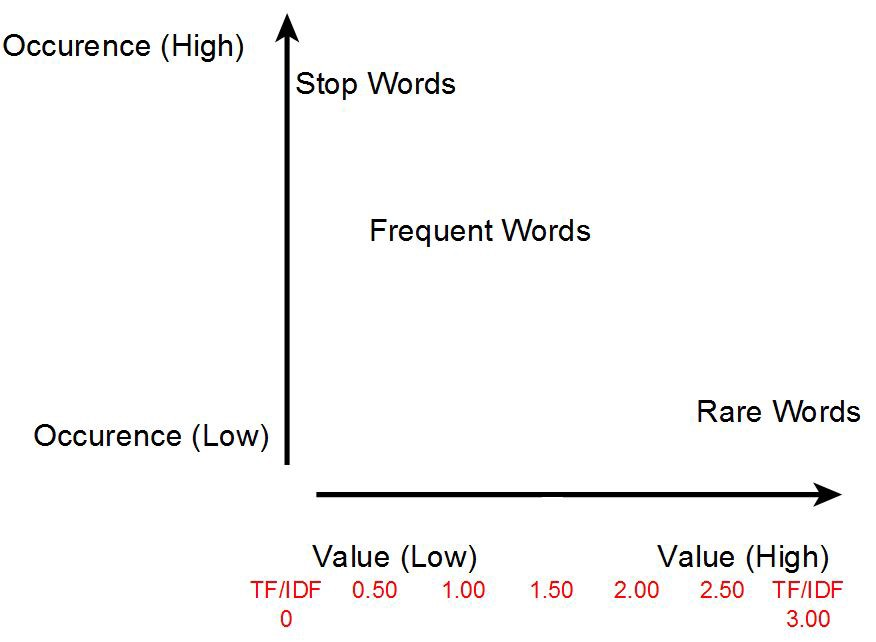

In [6]:
from IPython.display import Image
Image("tf-idf.jpeg")

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Beispiel für TF-IDF Werte von Wörtern

In [22]:
myvocabulary = ['life', 'learning']
corpus = {1: "The game of life is a game of everlasting learning", 2: "The unexamined life is not worth living", 3: "Never stop learning", 4: "Life is great. Keep on learning!"}
tfidf = TfidfVectorizer(vocabulary = myvocabulary, ngram_range = (1,3))
tfs = tfidf.fit_transform(corpus.values())

feature_names = tfidf.get_feature_names()
corpus_index = [n for n in corpus]
import pandas as pd
df = pd.DataFrame(tfs.T.todense(), index=feature_names, columns=corpus_index)
tfs = tfidf.fit_transform(corpus.values())
df.T

,life,learning
1,0.707107,0.707107
2,1.000000,0.000000
3,0.000000,1.000000
4,0.707107,0.707107


# Beispiel für Sätze

- Mit diesem Code lässt sich für beliebige Sätze deren "Entfernung" berechnen. 
- Man schaut wie stark sich sätze bzgl. der TF-IDF Scores der Wörter die wir analysieren ähneln. 
- Diese kann man dann nutzen um zu sehen welche Sätze ähnlich sind. 

In [10]:
vect = TfidfVectorizer(min_df=1)
corpus = ["I'd like an apple",
                            "An apple a day keeps the doctor away",
                            "Never compare an apple to an orange",
                            "I prefer scikit-learn to Orange"]
tfidf = vect.fit_transform(corpus)
apples_matrix = (tfidf * tfidf.T).A
apples_matrix

array([[1.        , 0.25082859, 0.39482963, 0.        ],
       [0.25082859, 1.        , 0.22057609, 0.        ],
       [0.39482963, 0.22057609, 1.        , 0.26264139],
       [0.        , 0.        , 0.26264139, 1.        ]])

# Visualisierung

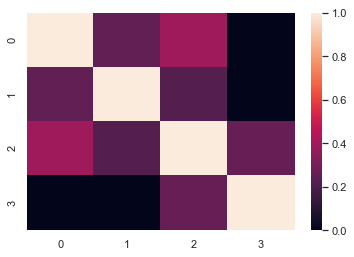

In [18]:
%matplotlib inline
import seaborn as sns; sns.set()
ax = sns.heatmap(apples_matrix)

# Beispiel für Dokumente mit Stemming und Stopword Entfernung

In [21]:
import nltk, string

text_files = ["godfather.txt", "schindlers_list.txt", "shawnshank.txt"]
documents = [open(f).read() for f in text_files]

# Stemming
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

#Remove punctuaction, stem
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english').fit_transform(documents)

# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = vectorizer * vectorizer.T
pairwise_similarity.A

array([[1.        , 0.09018803, 0.13309666],
       [0.09018803, 1.        , 0.10352998],
       [0.13309666, 0.10352998, 1.        ]])

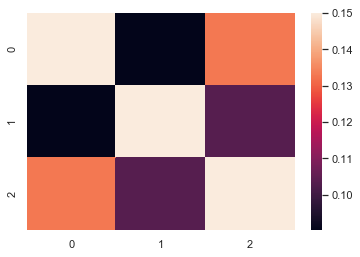

In [23]:
import seaborn as sns; sns.set()
ax = sns.heatmap(pairwise_similarity.A,vmax=0.15)

# Clustering
- Clustering ist ein statistisches Verfahren um "ähnliche" dinge zusammen in ein "Cluster" zu legen. 
- Wichtig ist dass je nach verfahren die Anzahl der Cluster definiert werden muss. Hier 3. 
- Das Clustering Verfahren das hier verwendet wird heisst k-Means (https://de.wikipedia.org/wiki/K-Means-Algorithmus)

## Für Sätze

In [1]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint


def word_tokenizer(text):
        #tokenizes and stems the text
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens


def cluster_sentences(sentences, nb_of_clusters=5):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        max_df=0.9,
                                        min_df=0.1,
                                        lowercase=True)
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        kmeans = KMeans(n_clusters=nb_of_clusters)
        # Clustering
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        return dict(clusters)


sentences = ["Nature is beautiful","I like green apples",
        "We should protect the trees","Fruit trees provide fruits",
        "Green apples are tasty"]

nclusters= 3
clusters = cluster_sentences(sentences, nclusters)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,sentence in enumerate(clusters[cluster]):
                print "\tsentence ",i,": ",sentences[sentence]

cluster  0 :
	sentence  0 :  Nature is beautiful
cluster  1 :
	sentence  0 :  I like green apples
	sentence  1 :  Green apples are tasty
cluster  2 :
	sentence  0 :  We should protect the trees
	sentence  1 :  Fruit trees provide fruits


## Für Textdokumente

In [26]:
text_files = ["godfather.txt", "schindlers_list.txt", "shawnshank.txt"]
sentences = [open(f).read() for f in text_files]

In [40]:
nclusters= 3
clusters = cluster_sentences(sentences, nclusters)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,document in enumerate(clusters[cluster]):
                print "\tdocument ",i,": ",text_files[document]

cluster  0 :
	document  0 :  shawnshank.txt
cluster  1 :
	document  0 :  schindlers_list.txt
cluster  2 :
	document  0 :  godfather.txt


In [41]:
from nltk.corpus import inaugural

In [48]:
sentences =[]
text_files = inaugural.fileids()
for id in inaugural.fileids():
    sentences.append((" ").join(inaugural.words(id)))

In [51]:
sentences[0][0:50]

u'Fellow - Citizens of the Senate and of the House o'

In [52]:
nclusters= 3
clusters = cluster_sentences(sentences, nclusters)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,document in enumerate(clusters[cluster]):
                print "\tdocument ",i,": ",text_files[document]

cluster  0 :
	document  0 :  1789-Washington.txt
	document  1 :  1793-Washington.txt
	document  2 :  1797-Adams.txt
	document  3 :  1801-Jefferson.txt
	document  4 :  1805-Jefferson.txt
	document  5 :  1809-Madison.txt
	document  6 :  1813-Madison.txt
	document  7 :  1817-Monroe.txt
	document  8 :  1821-Monroe.txt
	document  9 :  1825-Adams.txt
	document  10 :  1829-Jackson.txt
	document  11 :  1833-Jackson.txt
	document  12 :  1837-VanBuren.txt
	document  13 :  1841-Harrison.txt
	document  14 :  1845-Polk.txt
	document  15 :  1849-Taylor.txt
	document  16 :  1853-Pierce.txt
	document  17 :  1857-Buchanan.txt
	document  18 :  1861-Lincoln.txt
	document  19 :  1865-Lincoln.txt
	document  20 :  1869-Grant.txt
	document  21 :  1873-Grant.txt
	document  22 :  1877-Hayes.txt
	document  23 :  1881-Garfield.txt
	document  24 :  1885-Cleveland.txt
	document  25 :  1889-Harrison.txt
	document  26 :  1901-McKinley.txt
cluster  1 :
	document  0 :  1937-Roosevelt.txt
	document  1 :  1941-Roosevelt